# PJ's Variable reduction method

`1643.16.Jul.20`

PJ and Dr. Ning wrote a paper on the [Variable Reduction](https://scholarsarchive.byu.edu/facpub/3567/) method that was very good. I'm applying it to BYU's IEA participation, and it comes in two parts:

1) parameterize some turbines along the edge
2) parameterize interior turbines in a specific way

Though (2) will take some brain power, and could be fully automated, (1) should be relatively quick to code up. PJ wrote his original code in Python, so I'll need to translate that. It's not well commented, but we did a Video Call today and he explained each piece. I'll include it here below.

### PJ's Full Variable Reduction Code
`1650.16.Jul.20`

```python
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
import grid_param_fortran
warnings.simplefilter('ignore', np.RankWarning)
import sys
import grid_param_fortran
sys.path.insert(0, '/home/flowlab/PJ/reduction')
from position_constraints import *
sys.dont_write_bytecode = True


def startLoop(N,d,my,step,plus_minus,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t):
    d = d+plus_minus*d*step
    shear = np.tan(np.deg2rad(20.))*d
    X,Y = grid_param_fortran.makegrid_fortran(N, d, d*my, shear, rotate, turbs_per_row, x_start, y0)
    bounds = arbitraryBoundary(X, Y, boundaryVertices, boundaryNormals)
    num_inside = 0

    # plt.figure(1)
    # plt.clf()
    # for i in range(len(X)):
    #     circ = plt.Circle((X[i],Y[i]),130./2.)
    #     plt.gca().add_patch(circ)
    # bx = boundaryVertices[:,0]
    # by = boundaryVertices[:,1]
    # bx = np.append(bx,bx[0])
    # by = np.append(by,by[0])
    # plt.plot(bx,by,'--k')
    # plt.axis('equal')
    # plt.pause(0.0001)

    for i in range(t**2):
        if min(bounds[i]) >= 0.:
            num_inside += 1
    return num_inside,d


#fill an arbirary boundary with a baseline grid
def startGrid(nTurbines,boundaryVertices,boundaryNormals,rotate=0.,my=1.):
    xBounds = boundaryVertices[:, 0]
    yBounds = boundaryVertices[:, 1]

    t = 25
    range_x = (max(xBounds)-min(xBounds))
    range_y = (max(yBounds)-min(yBounds))
    d = 1.5*max(np.array([range_x,range_y]))/float(t)
    # rotate = 0.
    nRows = t
    turbs_per_row = np.ones(nRows,dtype=int)*t
    N = np.sum(turbs_per_row)

    # x_start = np.ones(t)*min(xBounds)-range_x*0.5
    x_start = np.zeros(t)
    y0 = min(yBounds)-0.05*range_y

    shear = np.tan(np.deg2rad(20.))*d
    X,Y = grid_param_fortran.makegrid_fortran(N, d, d*my, shear, rotate, turbs_per_row, x_start, y0)

    bounds = arbitraryBoundary(X, Y, boundaryVertices, boundaryNormals)
    num_inside = 0
    for i in range(t**2):
        if min(bounds[i]) >= 0.:
            num_inside += 1

    converged = False
    step = 0.25
    print 'setting up base grid'
    # print nTurbines
    while converged == False:
        while num_inside < nTurbines:
            num_inside,d = startLoop(N,d,my,step,-1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)
        while num_inside >= nTurbines:
            num_inside,d = startLoop(N,d,my,step,1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)

        if step < 1.E-8:
            converged = True
        else:
            step = step/2.
        # print step

    print 'final convergence'
    num_inside,d = startLoop(N,d,my,step,-1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)
    small_step = step/100.
    while num_inside >= nTurbines:
        num_inside,d = startLoop(N,d,my,small_step,1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)

    while num_inside < nTurbines:
        d = d-d*small_step
        shear = np.tan(np.deg2rad(20.))*d
        X,Y = grid_param_fortran.makegrid_fortran(N, d, d*my, shear, rotate, turbs_per_row, x_start, y0)
        bounds = arbitraryBoundary(X, Y, boundaryVertices, boundaryNormals)
        num_inside = 0
        for i in range(t**2):
            if min(bounds[i]) > 0.:
                num_inside += 1

    x = np.zeros(nTurbines)
    y = np.zeros(nTurbines)
    turb = 0
    index = 0
    while turb < nTurbines:
        if min(bounds[index]) >= 0.:
                x[turb] = X[index]
                y[turb] = Y[index]
                turb += 1
        index += 1

    dx = d
    dy = d*my
    turbineX = np.cos(-np.deg2rad(rotate))*x - np.sin(-np.deg2rad(rotate))*y
    turbineY = np.sin(-np.deg2rad(rotate))*x + np.cos(-np.deg2rad(rotate))*y
    y0 = np.min(turbineY)
    turbs_per_row = np.array([1])
    for i in range(nTurbines-1):
        if turbineY[i+1] < turbineY[i]+1E-4 and turbineY[i+1] > turbineY[i]-1E-4:
            turbs_per_row[-1] += 1
        else:
            turbs_per_row = np.append(turbs_per_row,1)

    shear = dy*np.tan(np.deg2rad(20.))
    nRows = len(turbs_per_row)
    x_start = np.zeros(nRows)
    x_start[0] = 0.0
    index = 1
    # for i in range(nTurbines-1):
    #     if not (turbineY[i+1] < turbineY[i]+1.E-4 and turbineY[i+1] > turbineY[i]-1.E-4):
    #         xs = turbineX[i+1]
    #         x_start[index] = (xs-shear-turbineX[sum(turbs_per_row[0:index-1])])/dx
    #         index += 1
    for i in range(nRows-1):
        x_start[i+1] = x_start[i] + (turbineX[sum(turbs_per_row[0:i+1])] - shear - turbineX[sum(turbs_per_row[0:i])])/dx

    # plt.figure(1)
    # for i in range(nTurbines):
    #     circ = plt.Circle((turbineX[i],turbineY[i]),130./2.,alpha=0.5,color='blue')
    #     plt.gca().add_patch(circ)
    #     circ = plt.Circle((x[i],y[i]),130./2.,alpha=0.5,color='red')
    #     plt.gca().add_patch(circ)
    # bx = boundaryVertices[:,0]
    # by = boundaryVertices[:,1]
    # bx = np.append(bx,bx[0])
    # by = np.append(by,by[0])
    # plt.plot(bx,by,'--k')
    # plt.axis('equal')
    # plt.show()

    return dx,dy,shear,rotate,turbs_per_row,x_start,y0


#makes a grid of points/turbines
def makeGrid(dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start):
    nRows = len(turbs_per_row)
    nTurbs = sum(turbs_per_row)
    x = np.zeros(nTurbs)
    y = np.zeros(nTurbs)
    index = 0
    for i in range(nRows):
        for j in range(turbs_per_row[i]):
            x[index] = x_start[i] + dx*j + float(i)*dy*np.tan(np.deg2rad(shearX))
            y[index] = y0 + dy*i + (float(j)+col_start[i])*dx*np.tan(np.deg2rad(shearY))
            index += 1
    xc = x - (max(x)+min(x))/2.
    yc = y - (max(y)+min(y))/2.
    xr = np.cos(np.deg2rad(rotate))*xc - np.sin(np.deg2rad(rotate))*yc
    yr = np.sin(np.deg2rad(rotate))*xc + np.cos(np.deg2rad(rotate))*yc
    return xr,yr


def find_lengths(x,y,nPoints):
    length = np.zeros(len(x)-1)
    for i in range(nPoints):
        length[i] = np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)
    return length


#places turbines spaced equally around the boundray of a wind farm
def makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=0.5):

    if xBounds[-1] != xBounds[0]:
        xBounds = np.append(xBounds,xBounds[0])
        yBounds = np.append(yBounds,yBounds[0])

    nBounds = len(xBounds)
    lenBound = find_lengths(xBounds,yBounds,len(xBounds)-1)
    circumference = sum(lenBound)
    spacing = 2.*np.sqrt(2.)
    x = np.array([])
    y = np.array([])

    N = int(circumference/(spacing*diameter))
    if N > nTurbs*frac:
        N = int(nTurbs*frac)
    bound_loc = np.linspace(start,start+circumference-circumference/float(N),N)
    for i in range(N):
        if bound_loc[i] > circumference:
            bound_loc[i] = bound_loc[i]%circumference
        while bound_loc[i] < 0.:
            bound_loc[i] += circumference

    for i in range(N):
        done = False
        for j in range(nBounds):
            if done == False:
                if bound_loc[i] < sum(lenBound[0:j+1]):
                    point_x = xBounds[j]+(xBounds[j+1]-xBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    point_y = yBounds[j]+(yBounds[j+1]-yBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    done = True
                    x = np.append(x,point_x)
                    y = np.append(y,point_y)

    return x,y


#determines the starting grid variables
def startTurbines(xBounds,yBounds,start,diameter,nTurbs,frac=0.5,my=2.):

    boundX, boundY = makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=frac)
    turbsRemaining = nTurbs - len(boundX)

    nBounds = len(xBounds)
    locations = np.zeros((nBounds,2))
    locations[:, 0] = xBounds*0.8
    locations[:, 1] = yBounds*0.8
    boundaryVertices, boundaryNormals = calculate_boundary(locations)
    dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start = startGrid(turbsRemaining,boundaryVertices,boundaryNormals,my=my)

    return dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start


#defines the layout of every turbine in a wind farm with the boundary section and the grid section
def turbineLocs(xBounds,yBounds,start,diameter,nTurbs,dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start,frac=0.5):
    boundX, boundY = makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=frac)
    gridX,gridY = makeGrid(dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start)
    turbineX = np.append(boundX,gridX)
    turbineY = np.append(boundY,gridY)

    return turbineX,turbineY



if __name__=="__main__":
    # locations = np.loadtxt('layout_amalia.txt')
    # xBounds = locations[:, 0]
    # yBounds = locations[:, 1]
    # xBounds = xBounds - min(xBounds) - (max(xBounds)-min(xBounds))/2.
    # yBounds = yBounds - min(yBounds) - (max(yBounds)-min(yBounds))/2.

    circle_radius = 5000.
    nBounds = 20
    locations = np.zeros((nBounds,2))
    xBounds = np.zeros(nBounds)
    yBounds = np.zeros(nBounds)
    theta = np.linspace(0.,2.*np.pi-2.*np.pi/float(nBounds),nBounds)
    for i in range(nBounds):
        xBounds[i] = circle_radius*np.cos(theta[i])
        yBounds[i] = circle_radius*np.sin(theta[i])

    locations[:, 0] = xBounds
    locations[:, 1] = yBounds

    boundaryVertices, boundaryNormals = calculate_boundary(locations)
    xBounds = boundaryVertices[:, 0]
    yBounds = boundaryVertices[:, 1]
    start = 0.
    diameter = 130.
    nTurbs = 100

    # dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start = startGrid(50,boundaryVertices,boundaryNormals)
    # print 'shearX: ', shearX
    # print 'shearY: ', shearY
    # print 'turbs_per_row: ', turbs_per_row
    # print 'dy: ', dy
    # # x_start = np.zeros(len(turbs_per_row))
    # turbineX, turbineY = makeGrid(dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start)
    # nTurbs = len(turbineX)

    dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start = startTurbines(xBounds,yBounds,start,diameter,nTurbs,frac=0.5,my=1.)
    turbineX, turbineY = turbineLocs(xBounds,yBounds,start,diameter,nTurbs,dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start,frac=0.5)

    xBounds = boundaryVertices[:,0]
    yBounds = boundaryVertices[:,1]
    xBounds = np.append(xBounds,xBounds[0])
    yBounds = np.append(yBounds,yBounds[0])
    plt.plot(xBounds,yBounds,'--k')
    plt.plot(turbineX,turbineY,'o')
    for i in range(nTurbs):
        plt.text(turbineX[i],turbineY[i],'%s'%i)
    plt.axis('equal')
    plt.show()
```

### First Functions to Translate to Julia
`1652.16.Jul.20`

```python
def find_lengths(x,y,nPoints):
    length = np.zeros(len(x)-1)
    for i in range(nPoints):
        length[i] = np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)
    return length


#places turbines spaced equally around the boundray of a wind farm
def makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=0.5):

    if xBounds[-1] != xBounds[0]:
        xBounds = np.append(xBounds,xBounds[0])
        yBounds = np.append(yBounds,yBounds[0])

    nBounds = len(xBounds)
    lenBound = find_lengths(xBounds,yBounds,len(xBounds)-1)
    circumference = sum(lenBound)
    spacing = 2.*np.sqrt(2.)
    x = np.array([])
    y = np.array([])

    N = int(circumference/(spacing*diameter))
    if N > nTurbs*frac:
        N = int(nTurbs*frac)
    bound_loc = np.linspace(start,start+circumference-circumference/float(N),N)
    for i in range(N):
        if bound_loc[i] > circumference:
            bound_loc[i] = bound_loc[i]%circumference
        while bound_loc[i] < 0.:
            bound_loc[i] += circumference

    for i in range(N):
        done = False
        for j in range(nBounds):
            if done == False:
                if bound_loc[i] < sum(lenBound[0:j+1]):
                    point_x = xBounds[j]+(xBounds[j+1]-xBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    point_y = yBounds[j]+(yBounds[j+1]-yBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    done = True
                    x = np.append(x,point_x)
                    y = np.append(y,point_y)

    return x,y
```

### Julia version of placeBndryTurbs()

In [229]:
#=== Set everything up for FlowFarm ===#
cd("/Users/nbaker/Documents/GitHub/FlowFarm.jl/test/")
include("iea37_specific_functions.jl")
using FlowFarm; const ff = FlowFarm
import YAML
using PyPlot
using CSV

#--- Read in windfarm boundary data ---#
# Which case study we're doing. 'cs3' or 'cs4'
str_case = "4"
#- Rip the boundary coordinates from the .yaml file -#
file_dir = "./inputfiles/"
bnry_file_name_orig = "iea37-boundary-cs" * str_case * ".yaml"
bnry_file_name = string(file_dir,bnry_file_name_orig)
bndry_x, bndry_y = getBndryCs4YAML(bnry_file_name)
bndry_x_clsd, bndry_y_clsd = ff.closeBndryLists(bndry_x, bndry_y)

#--- Determine the number of turbines in each region --- #
nNumRegions = 5     # Number of reigons we're using (cs4 = 5, cs3 = 1)
fFracBrdr = 0.6    # Fraction of turbines on the boundary (0.45 recommended by the paper)
turbs_per_region = zeros(Int8, nNumRegions)  # Preallocated turbines in each region
turbs_region_brdr = zeros(Int8, nNumRegions)  # Preallocated turbines for each region's boundary
for cntr in 1:nNumRegions
    turbs_per_region[cntr] = floor(getCs34NumTurbs(getCs34Name(cntr)))
    # Determine the number of turbines on the border
    turbs_region_brdr[cntr] = round(turbs_per_region[cntr] * fFracBrdr)
end
num_tot_turbs = sum(turbs_per_region)

#-- Debug Print --#
println("Num region turbines:")
for i in 1:nNumRegions
    print(i, ": ")
    println(turbs_per_region[i])
end
println()
println("Num border turbines:")
for i in 1:nNumRegions
    print(i, ": ")
    println(turbs_region_brdr[i])
end

Num region turbines:
1: 31
2: 11
3: 16
4: 14
5: 9

Num border turbines:
1: 19
2: 7
3: 10
4: 8
5: 5


In [230]:
# For a set of closed boundary points, returns the length along the perimeter
function getPerimeterLength(bndry_x_clsd, bndry_y_clsd)
    num_bndry_pts = length(bndry_x_clsd)-1
    nLength = zeros(num_bndry_pts)
    for i in 1:num_bndry_pts
        nLength[i] = sqrt(
                 (bndry_x_clsd[i+1]-bndry_x_clsd[i])^2
                +(bndry_y_clsd[i+1]-bndry_y_clsd[i])^2)
    end
    
    return nLength
end

println(getPerimeterLength(bndry_x_clsd[1], bndry_y_clsd[1]))

[283.8842193571172, 68.30790583819758, 294.62004344579145, 213.38533220444143, 212.17881609623433, 211.89669652923007, 207.17885992542682, 693.4318784134465, 64.2262407431732, 3937.461725528262, 2644.138545916231, 1898.470523869148, 10.201960595885481, 233.30105014765792, 265.33484505432, 431.6559046277485, 549.190904877348, 4972.836255096281]


In [231]:
#- Physically place the turbines -# 
function placeBndryTurbs(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_dist, num_turbs)
    # Initialize necessary variables
    num_segs = length(bndry_x_clsd)-1
    #- Get arc-length -#
    bndry_seg_length = getPerimeterLength(bndry_x_clsd,bndry_y_clsd)
    bndry_tot_length = sum(bndry_seg_length)

    #- Determine how much distance between each turbine -#
    turb_corner_spacing = 2*(turb_min_dist/sind(90.0 / 2.0)) # for 30deg angle ...## 2.*sqrt(2.)  # For 90deg angles
    
    if (turb_corner_spacing > turb_min_dist)   # If the corners are tighter than our minimum distance
        turb_min_dist = turb_corner_spacing    # That dictates our new minimum distance
        println("Corner constrained")
    end
    #- Determine how many turbines we can actually place -#
    max_num_turbs = floor(Int, bndry_tot_length/turb_min_dist) # Get max number of turbines that can fit the perimeter
    num_leftover_turbs = 0
    if (max_num_turbs < num_turbs)      # If the max is less than the number allocated
        num_leftover_turbs = floor(Int, num_turbs - max_num_turbs) # Note how many turbines we aren't placing
        num_turbs = floor(Int, max_num_turbs)       # Make the number as many as will fit
        println("Spacing constrained")
    end

    #- Evenly space the turbines we'll place -#
    turb_min_dist = bndry_tot_length / num_turbs
    
    #- Make sure our start point is within the boundary length bounds
    start_dist = mod(start_dist, bndry_tot_length)
    
    # Initialize turbine locations
    turbine_x = zeros(num_turbs)   #- initialize number of turbines -#
    turbine_y = zeros(num_turbs)   #- initialize number of turbines -#

    #- Figure out where the starting point should be -#
    leg_remaining = start_dist
    curr_seg = 1
    for i in 1:num_segs   # Looping through the segments till we get there
        curr_seg = i
        if (bndry_seg_length[i] < leg_remaining)  # If this segment length is less than the start length
            leg_remaining -= bndry_seg_length[i]  # Clip the start length and move to the next one
        else                                        # Otherwise the start point is on this segment
            percent_to_start = leg_remaining / bndry_seg_length[i] # How far along our segment we are
            # Translate how far along the segment we are to actual x- y-coords
            turbine_x[1] = bndry_x_clsd[i] + ((bndry_x_clsd[i+1] - bndry_x_clsd[i]) * percent_to_start)
            turbine_y[1] = bndry_y_clsd[i] + ((bndry_y_clsd[i+1] - bndry_y_clsd[i]) * percent_to_start)
            break
        end
    end
    # Get how much distance is left on this leg after the starting point
    percent_left_of_segment = 1 - abs((turbine_x[1] - bndry_x_clsd[curr_seg]) / (bndry_x_clsd[curr_seg+1] - bndry_x_clsd[curr_seg]))
    seg_remaining = bndry_seg_length[curr_seg] * percent_left_of_segment
    leg_remaining = turb_min_dist
    
    #- Place the rest of the turbines -#
    for i in 2:num_turbs    # For every turbine we have to place
        if(seg_remaining > leg_remaining)   #- If there's space on this leg to place the next turbine
            percent_to_place = (bndry_seg_length[curr_seg] - seg_remaining + turb_min_dist) / bndry_seg_length[curr_seg]
            seg_remaining -= turb_min_dist # Take out the distance we used
        else                                #- If there isn't enough space on this boundary segment to place the next turbine
            while(seg_remaining < leg_remaining)           # Keep checking boundary segments until we reach the next placement
                leg_remaining -= seg_remaining             # Subtract that much till our next placement
                curr_seg = mod(curr_seg, (num_segs))+1   # Increment what segment we're onspot
                seg_remaining = bndry_seg_length[curr_seg] # Reset how much segment length we have left
            end
            percent_to_place = leg_remaining / bndry_seg_length[curr_seg]
            seg_remaining = bndry_seg_length[curr_seg] - leg_remaining
        end
        #- Place the turbines the appropriate distance from the segment start point -#
        turbine_x[i] = bndry_x_clsd[curr_seg] + ((bndry_x_clsd[curr_seg+1] - bndry_x_clsd[curr_seg]) * percent_to_place)
        turbine_y[i] = bndry_y_clsd[curr_seg] + ((bndry_y_clsd[curr_seg+1] - bndry_y_clsd[curr_seg]) * percent_to_place)
        leg_remaining = turb_min_dist  # Reset how much length till the next turbine is placed
    end

    # Return the x- and y- coordinates of every turbine, and how many weren't placed
    return turbine_x,turbine_y, num_leftover_turbs         
end

placeBndryTurbs (generic function with 2 methods)

`0000.17.Jul.20`

I'm getting a little tired. The only thing left to do is the allocation portion. PJ had it so that he looped through every turbine, placing them where they are supposed to be. The way I did it previously for my mapping method, was walking along the perimeter and placing them as I go. I think that's the more intuitive way, so I'm going to code it up that way.

`1858.20.Jul.20`

Back at it.

`1637.21.Jul.20`

I think I finished it. I'll need to test now.

In [232]:
# Place the turbines for the first area
layout_file_name = "./inputfiles/iea37-ex-opt4.yaml"
~, ~, fname_turb, ~ = ff.get_turb_loc_YAML(layout_file_name)
turbine_file_name = string("./inputfiles/",fname_turb)
~, ~, ~, ~, turb_diam, ~ = ff.get_turb_atrbt_YAML(turbine_file_name)
turb_min_space = 2*turb_diam

start_dist = 0
test_num_turbs = 200
region = 1  # Which region we're placing turbines for
turbine_x, turbine_y, not_placed = placeBndryTurbs(bndry_x_clsd[region], bndry_y_clsd[1], start_dist, turb_min_space, test_num_turbs)#turbs_region_brdr[region])
print("Not Placed:", not_placed)

Corner constrained
Spacing constrained
Not Placed:185

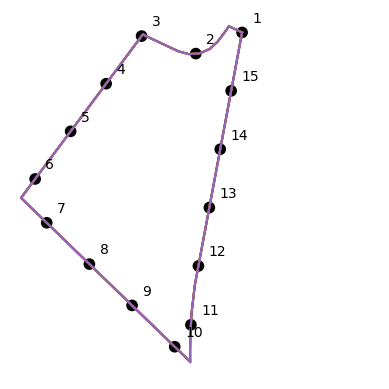

In [305]:
#- Visualize it all -#
# Plot boundary
for cntr in 1:nNumRegions
    plot(bndry_x_clsd[region], bndry_y_clsd[region])
end

# Plot turbines
for i = 1:length(turbine_x)
     plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), turb_diam/2.0, fill=true,color="black"))
     plt.text(turbine_x[i]+turb_diam,turbine_y[i]+turb_diam, string(i))
end

# Formatting
axis("square")
axis("off")
plt.show()

`1749.21.Jul.20`

Finished and tested.

I now need to do three cleanup things:
- [ ] Write function determining min distance around corners
- [ ] Figure out how to put leftovers back into main area
- [ ] put into FlowFarm.jl and test

`2129.21.Jul.20`

I have a problem with calculating the interior angles of three points. It seems to be undercalculating the angle. I'll need to revisit it in the morning.

In [301]:
# Determines the minimum distance around a boundary, based on corners
function getMinLength(bndry_x_clsd, bndry_y_clsd, turb_min_dist)
    #- Calculate the smallest angle -#
    smallest_angle = calcSmallestAngle(bndry_x_clsd, bndry_y_clsd)
    
    #- Calc the radius of the circumscribed circle -#
    # c = r * sin(Theta/2)
    r = (2 * turb_min_dist) / sin( theta/2 )
    #- Calc the distance to the chord -#
    # Pythagorean theorem
    h = sqrt(r^2 - turb_min_dist^2)
    
    # The `actual` min distance along the boundary length
    turb_spacing_around_smallest_corner = r + h
    
    return turb_spacing_corner
end

function calcMinorAngle(bndry_x, bndry_y, bndry_z=[0,0,0])
    # <bndry_x> is a 3-element 1-D array that is the x- coordinates of three points.
    # Calculates the magnitude of the interior angle formed at the center point
    ABx = bndry_x[2]-bndry_x[1]
    ABy = bndry_y[2]-bndry_y[1]
    ABz = bndry_z[2]-bndry_z[1]
    
    BCx = bndry_x[3]-bndry_x[2]
    BCy = bndry_y[3]-bndry_y[2]
    BCz = bndry_z[3]-bndry_z[2]
    
    Num = (ABz*BCx) + (ABy*BCy) + (ABx*BCz) # Dot Product
    
    Denom = sqrt(ABx^2 + ABy^2 + ABz^2) * sqrt(BCx^2 + BCy^2 + BCz^2)
    Theta = mod(acosd(Num/Denom), 360)
    
    return Theta
end

function calcSmallestAngle(bndry_x_clsd, bndry_y_clsd)
    num_angles = length(bndry_x_clsd)-1
    # Loop the second point back on so we get the angle at the beginning
    if !(((bndry_x[1] == bndry_x[end-1]) && (bndry_y[1] == bndry_y[end-1])) && ((bndry_x[2] == bndry_x[end]) && (bndry_y[2] == bndry_y[end])))
        bndryPts_x_loopd = vcat(bndry_x_clsd, bndry_x_clsd[2])
        bndryPts_y_loopd = vcat(bndry_y_clsd, bndry_y_clsd[2])
    end
    
    #- Calculate the smallest angle -#
    smallest_angle = 360
    for i in 1:num_angles
        temp_angle = calcMinorAngle(bndryPts_x_loopd[i:i+2], bndryPts_y_loopd[i:i+2])

        if (temp_angle < smallest_angle)
            smallest_angle = temp_angle
        end
    end
    
    return smallest_angle
end

calcSmallestAngle (generic function with 1 method)

In [302]:
#Test
calcAngle([1,3,1], [2,2,1], [3,1,1])

50.768479516407744

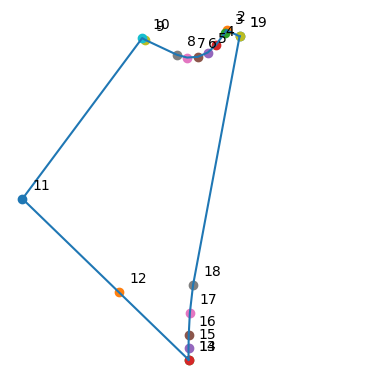

19


In [303]:
# Plot boundary
bndry_x = bndry_x_clsd[region]
bndry_y = bndry_y_clsd[region]

plot(bndry_x, bndry_y)
num_bndry_pts = length(bndry_x)
println(num_bndry_pts)
#scatter(bndry_x[20],bndry_y[20])#, turb_diam/2.0, fill=true,color="black")
# Plot boundary verticies
for i = 1:num_bndry_pts
     scatter(bndry_x[i],bndry_y[i])#, turb_diam/2.0, fill=true,color="black")
     plt.text(bndry_x[i]+turb_diam, bndry_y[i]+turb_diam, string(i))
end

# Formatting
axis("square")
axis("off")
plt.show()

In [304]:
calcSmallestAngle(bndry_x_clsd[region], bndry_y_clsd[region])

111.41065852486847
111.41065852486847

46.6837663990823
46.6837663990823

56.905654154264546
56.905654154264546

74.29775797784077
74.29775797784077

88.44577573314223
88.44577573314223

91.0371111042293
91.0371111042293

83.54124375056553
83.54124375056553

77.3784346251804
77.3784346251804

114.334858762265
114.334858762265

56.08477420066962
56.08477420066962

61.05105139923237
61.05105139923237

45.92620835125957
45.92620835125957

178.86362034338742
178.86362034338742

0.9443504657601127
0.9443504657601127

3.052669969689634
3.052669969689634

7.169149687115191
7.169149687115191

12.437093099396675
12.437093099396675

65.27428951144134
65.27428951144134



0.9443504657601127